THIS IS THE WORKING STREAMING NOTEBOOK

In [1]:
import nifgen
import numpy as np
import matplotlib.pyplot as plt
import time

CREATING RIPPLE PATTERN FOR TESTING

This will output "waveform_rows" which can be used for sequences

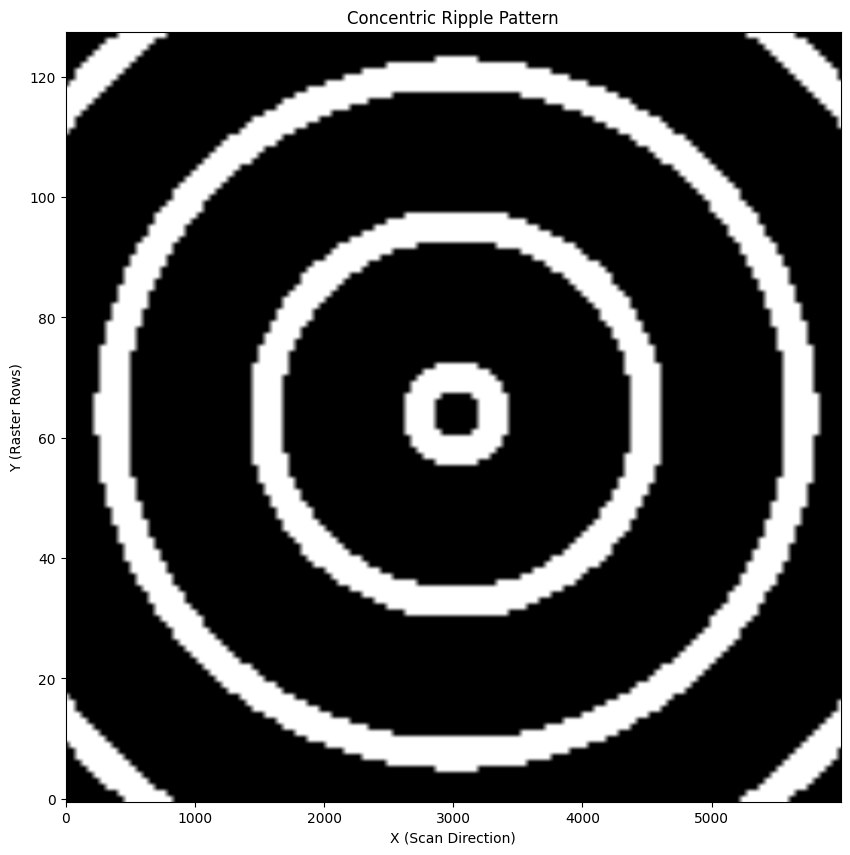

In [225]:
sampling_rate = 100_000_000  # 100 MHz
line_duration_us = 60
samples_per_line = sampling_rate * line_duration_us // 1_000_000  # 6,300 samples per line

height, width = 128, 128  
pattern = np.zeros((height, width))
cx, cy = width // 2, height // 2

# Generate ripple pattern
for y in range(height):
    for x in range(width):
        distance = np.sqrt((x - cx) ** 2 + (y - cy) ** 2)
        wave = 0.5 * (np.sin(0.25 * distance) + 1)
        pattern[y, x] = 1.0 if wave > 0.9 else 0.0

waveform_rows = []
for row in pattern:
    original_indices = np.linspace(0, 1, width)
    target_indices = np.linspace(0, 1, samples_per_line)
    active_row = np.interp(target_indices, original_indices, row).astype(np.float64)
    blank_row = np.zeros_like(active_row)
    waveform_rows.append(active_row)
    
# Show the final pattern visually
plt.figure(figsize=(10, 10))
plt.imshow(waveform_rows, cmap='gray', aspect='auto', origin='lower')
plt.title("Concentric Ripple Pattern")
plt.xlabel("X (Scan Direction)")
plt.ylabel("Y (Raster Rows)")
plt.grid(False)
plt.show()


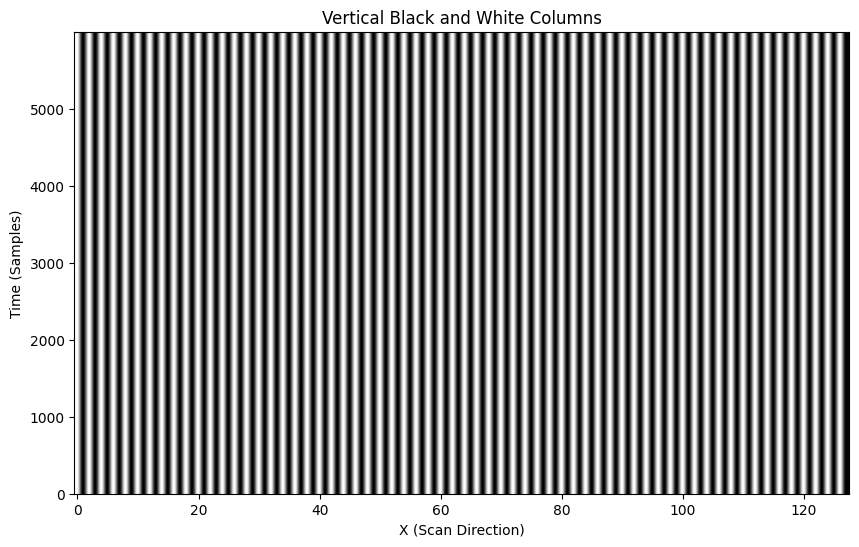

In [247]:
# Recreate the pattern to produce vertical black and white stripes over time

sampling_rate = 100_000_000  # 100 MHz
line_duration_us = 60
samples_per_line = sampling_rate * line_duration_us // 1_000_000  # 6,300 samples per line

height, width = 128, 128  # height = columns over time; width = number of lines

# Create alternating black and white columns (temporal signal over time)
pattern = np.zeros((samples_per_line, width))
for x in range(width):
    if x % 2 == 0:
        pattern[:, x] = 1.0  # white column

# Each row in 'pattern' is a full waveform line (left to right)
waveform_rows = [row.astype(np.float64) for row in pattern]

# Show the final pattern visually
plt.figure(figsize=(10, 6))
plt.imshow(waveform_rows, cmap='gray', aspect='auto', origin='lower')
plt.title("Vertical Black and White Columns")
plt.xlabel("X (Scan Direction)")
plt.ylabel("Time (Samples)")
plt.grid(False)
plt.show()


We can load each of these rows individually and create a sequence with them. Everytime a trigger happens, the next row gets output

In [240]:
with nifgen.Session("Dev1") as session:
    session.output_mode = nifgen.OutputMode.SEQ
    session.arb_sample_rate = 100_000_000
    session.streaming_write_timeout = 30.0

    # Create waveform handle array and loop counts for sequence
    waveform_handle_array = []
    loop_counts = []

    for row in waveform_rows:
        waveform_handle_array.append(session._create_waveform_f64_numpy(row))
        loop_counts.append(1)

    # Load waveform handle array and loop counts to make a sequence
    sequence_handle = session.create_arb_sequence(waveform_handle_array, loop_counts)

    # Configuring the sequence with the sequence handle
    session.configure_arb_sequence(sequence_handle, 1, 0)

    # Add a trigger to start the next waveform
    session.start_trigger_type                = nifgen.StartTriggerType.DIGITAL_EDGE
    session.digital_edge_start_trigger_source = "/Dev1/PFI1"
    session.digital_edge_start_trigger_edge   = nifgen.StartTriggerDigitalEdgeEdge.RISING
    session.trigger_mode                      = nifgen.TriggerMode.STEPPED

    # Initiate session
    session.initiate()

    time.sleep(10)

This works, but only because the whole waveform is only 24MB and fits on the waveform generator memory

In [227]:
full_shape = np.concatenate(waveform_rows)
full_shape.nbytes / 1024 / 1024

5.859375

For large waveforms, we need to stream them in. We can try that by multiplying this same waveform over and over, and then trying to stream it.

In [231]:
large_ripple = np.concatenate([full_shape] * 55)
large_ripple.nbytes / 1024 / 1024

322.265625

Need to chunk it for streaming

In [232]:
arr = large_ripple.astype(np.float64)

# Max allocation space in bytes83886080
max_mem = 80 * 1024 * 1024  # 160 MiB = 167_772_160 bytes
target_chunk = max_mem // 10  # Ideal chunk size ~16.7 MiB

# Find best chunk size that evenly divides max_mem
for chunk_size in range(target_chunk, 0, -1):
    if max_mem % chunk_size == 0:
        break  # Found the best chunk size

# Now compute how many elements that is
bytes_per_element = arr.itemsize
elements_per_chunk = chunk_size // bytes_per_element

print(f"Max mem: {max_mem} bytes")
print(f"Chunk size: {chunk_size} bytes")
print(f"Elements per chunk: {elements_per_chunk}")
print(f"Initial chunks to load: {max_mem // chunk_size}")
print(f"Total chunks needed: {int(np.ceil(arr.nbytes / chunk_size))}")

Max mem: 83886080 bytes
Chunk size: 8388608 bytes
Elements per chunk: 1048576
Initial chunks to load: 10
Total chunks needed: 41


In [233]:
chunks = [arr[i:i+elements_per_chunk] for i in range(0, len(arr), elements_per_chunk)]
len(chunks)

41

In [238]:
with nifgen.Session("Dev1") as session:
    session.output_mode = nifgen.OutputMode.ARB
    session.arb_sample_rate = 20_000_000

    waveform_handle = session.allocate_waveform(83886080)
    session.streaming_waveform_handle = waveform_handle

    session.start_trigger_type                = nifgen.StartTriggerType.DIGITAL_EDGE
    session.digital_edge_start_trigger_source = "/Dev1/PFI1"
    session.digital_edge_start_trigger_edge   = nifgen.StartTriggerDigitalEdgeEdge.RISING
    session.trigger_mode                      = nifgen.TriggerMode.SINGLE
    
    j = 0 
    while session.streaming_space_available_in_waveform > chunk_size:
        session.write_waveform(waveform_handle, chunks[j])
        print(f'Wrote chunk: {j}')
        print(f'Space left: {session.streaming_space_available_in_waveform}')
        j += 1
        if j == len(chunks):
            break

    # Initiate
    session.initiate()
    session.wait_until_done()
    # Write the rest of the chunks
    for i in range(j, len(chunks)):
        session.write_waveform(waveform_handle, chunks[i])
        print(f'Wrote chunk: {j}')
        j+=1
        print(f'Space left: {session.streaming_space_available_in_waveform}')

    

Wrote chunk: 0
Space left: 82837504
Wrote chunk: 1
Space left: 81788928
Wrote chunk: 2
Space left: 80740352
Wrote chunk: 3
Space left: 79691776
Wrote chunk: 4
Space left: 78643200
Wrote chunk: 5
Space left: 77594624
Wrote chunk: 6
Space left: 76546048
Wrote chunk: 7
Space left: 75497472
Wrote chunk: 8
Space left: 74448896
Wrote chunk: 9
Space left: 73400320
Wrote chunk: 10
Space left: 72351744
Wrote chunk: 11
Space left: 71303168
Wrote chunk: 12
Space left: 70254592
Wrote chunk: 13
Space left: 69206016
Wrote chunk: 14
Space left: 68157440
Wrote chunk: 15
Space left: 67108864
Wrote chunk: 16
Space left: 66060288
Wrote chunk: 17
Space left: 65011712
Wrote chunk: 18
Space left: 63963136
Wrote chunk: 19
Space left: 62914560
Wrote chunk: 20
Space left: 61865984
Wrote chunk: 21
Space left: 60817408
Wrote chunk: 22
Space left: 59768832
Wrote chunk: 23
Space left: 58720256
Wrote chunk: 24
Space left: 57671680
Wrote chunk: 25
Space left: 56623104
Wrote chunk: 26
Space left: 55574528
Wrote chunk

DriverError: -1074118519: Failed to retrieve error description.